# Trading Environment simulator

Within this notebook you can follow the development process of the Trading Environment as a simulator compatible with OpenAI Gym.

This notebook is divided in two different sections:

1- Environment design: where I describe in which it works and provide a cell with the python code of the implementation.

2- Environment test: In this second section, I use the installed version of this environment, to test random actions.

Let's start!!

### 1 Environment design

The Trading Environment is coded in python as a class named ```TradeSimEnv``` and derived from ```gym.Env```, providing the common interface that every environment should provide: functions ```reset```, ```step``` and ```render```.

It includes an internal class ```AccountStatus``` that provides an abstract representation of an Investment Account. This class provides 2 callbacks:

- ```cb_tick``` to receive real-time quotes (bid, ask) from an external data source.

- ```cb_market``` to connect with the trading platform for receiving account status information and for sending trading action requests.

Depending on the attachments done on those callbacks, we can emulate both connections. In this notebook we will provide an external pandas dataframe with historic quotes, to emulate the real-time quotes generation, and on the other side, we'll use the internal Trading Platform emulator instead a real connection with the Broker's TP.


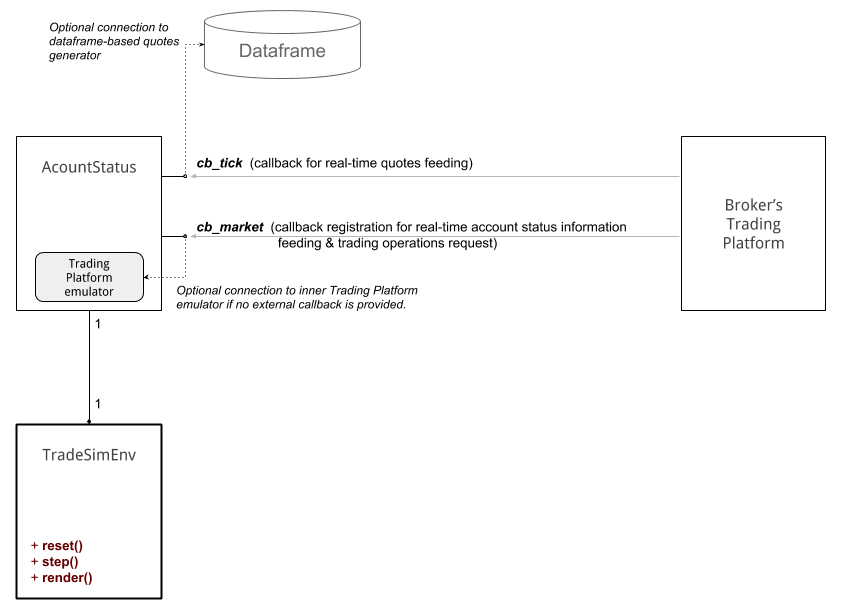


In [ ]:
# Let's import required libraries
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
from enum import Flag, auto
import copy

In [2]:
# Let's define the Trading environment class: TradeSimEnv
    
##############################################################################################3
class TradeSimEnv(gym.Env):

  metadata = {'render.modes': ['human']}
  NumActions = 5
  NumStates = 12
  InitialEquity = 1000.0
  Leverage = 1.0
  Commissions = 0.05
  TakeStopMargin = 0.2

  # Rewards
  RewardOnInvalidOperation = -2.0
  RewardOnCloseManually    = -1.0
  RewardOnCloseByStoploss  = -0.5
  RewardOnHighProfit       =  1.0

  class AccountStatus:

    class Signals(Flag):
      NoSignals         = 0
      PositionOpened    = auto()
      PositionClosed    = auto()
      StopLossReached   = auto()
      InvalidOperation  = auto()
      MarginCallReached = auto()
      NoMoney           = auto()
    

    #-------------------------------------------------------------------------------------
    def __init__(self, instrument, initial_equity, leverage, commissions, cb_tick, cb_market=None):
      """ Constructor:
      Args:
        instrument     : Instrument:  'eurusd_h1'
        initial_equity : Initial Equity
        leverage       : Initial Leverage
        commissions    : Commissions per operation
        cb_tick        : Callback for quote feed
        cb_market      : Callback market feed (default: self._market_query)
      """
      self.instrument = instrument
      self.tick = {'ask':0.0, 'bid':0.0}
      self.cb_tick = cb_tick
      self.cb_market = cb_market if cb_market is not None else self._market_query
      self.risk = 0.01  # 1% riesgo fijo
      self.commissions = commissions
      self.leverage = leverage  # ej. 30 => 30:1 
      self.initial_equity = initial_equity
      self.reset()
    
    #-------------------------------------------------------------------------------------
    def reset(self):
      """ Init account state
      """
      self.position = None
      self.last_position = None
      self.floatpl = 0
      self.pl = 0
      self.margin = 0    
      self.balance = self.initial_equity    
      self.equity = self.balance + self.floatpl
      self.free_margin = self.equity - self.margin
      self.margin_level = 100 * self.equity
      self.margin_call  = False   

    #-------------------------------------------------------------------------------------
    def updateStat(self, step):
      """ Update account state. One update per step
      """
      result = TradeSimEnv.AccountStatus.Signals.NoSignals
      self.tick = self.cb_tick(self.instrument, step)
      if self.position is not None:
        self.position, account_stat, result = self.cb_market(op='info', position=self.position)
        if self.position['stat'] == 'closed':
          self.last_position = copy.deepcopy(self.position)
          self.position = None
        self.balance  = account_stat['balance']
        self.equity  = account_stat['equity']
        self.margin = account_stat['margin']
        self.floatpl  = account_stat['floatpl']
        self.free_margin  = account_stat['free_margin']
        self.margin_level  = account_stat['margin_level']
        self.margin_call  = account_stat['margin_call']    
        self.pl = account_stat['pl']
      return result

    #-------------------------------------------------------------------------------------
    def openPosition(self, type='long', sl=None, tp=None):
      """ Try to open a position
      Args:
        type  : Position type 'long', 'short'
        sl    : Stop-loss
        tp    : Take-profit
      Returns: 
        Success, Description
      """     
      if self.position is not None:        
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation
      position = {}
      position['volume'] = self.risk * self.equity
      if position['volume'] > self.free_margin:
        return TradeSimEnv.AccountStatus.Signals.NoMoney

      position['margin'] = position['volume']/self.leverage
      position['type'] = type
      position['sl'] = sl
      position['tp'] = tp
      position['ratio_tpsl'] = 0

      # invoco callback para obtener precio de apertura
      position, account_stat, result = self.cb_market(op='open', position=position)
      if position['stat'] != 'opened':
        return result | TradeSimEnv.AccountStatus.Signals.InvalidOperation   

      # actualizo posición en curso
      self.position = position
      self.last_position = None
      
      # actualizo el estado de la cuenta
      self.balance  = account_stat['balance']
      self.equity  = account_stat['equity']
      self.margin = account_stat['margin']
      self.floatpl  = account_stat['floatpl']
      self.pl  = account_stat['pl']
      self.free_margin  = account_stat['free_margin']
      self.margin_level  = account_stat['margin_level']
      self.margin_call  = account_stat['margin_call']    
      return result

    #-------------------------------------------------------------------------------------
    def closePosition(self, type='long'):
      """ Try to close an opened position
      Args:
        type  : Type 'long', 'short'
      Returns: 
        Success, Description
      """      
      if self.position is None:
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      if self.position['type'] != type:
        return TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      self.position, account_stat, result = self.cb_market(op='close', position=self.position)
      if self.position['stat'] != 'closed':
        return result | TradeSimEnv.AccountStatus.Signals.InvalidOperation 
      self.last_position = copy.deepcopy(self.position)
      self.position = None
      self.balance  = account_stat['balance']
      self.equity  = account_stat['equity']
      self.margin = account_stat['margin']
      self.floatpl  = account_stat['floatpl']
      self.free_margin  = account_stat['free_margin']
      self.margin_level  = account_stat['margin_level']
      self.margin_call  = account_stat['margin_call'] 
      self.pl = account_stat['pl']
      return result

    #-------------------------------------------------------------------------------------
    def _market_query(self, op='none', position=None):
      """ Callback for market access 'cb_market'
      Args:
        op       : Operation type 'open, close, info, none'
        position : Opened position or None
      Returns: 
        Position,AccountStat
      """    
      result = TradeSimEnv.AccountStatus.Signals.NoSignals
      account_stat = {
        'balance': self.balance,
        'equity' : self.equity,
        'margin' : self.margin,
        'floatpl': self.floatpl,
        'free_margin': self.free_margin,
        'margin_level': self.margin_level,
        'margin_call': self.margin_call,
        'pl': self.pl
      }
      if op=='open':
        position['open_price'] = self.tick['ask'] if position['type']=='long' else self.tick['bid']  
        position['price'] = position['open_price']        
        position['stat'] = 'opened'
        account_stat['balance'] = self.balance
        account_stat['pl'] = self.pl
        account_stat['floatpl'] = 0
        account_stat['equity'] = self.equity + account_stat['floatpl']
        # update margin
        account_stat['margin'] = position['margin']
        # update free margin
        account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
        # calculate margin level
        account_stat['margin_level'] = 100 * (account_stat['equity']/account_stat['margin'])
        # check margin call
        account_stat['margin_call'] = False
        result |= TradeSimEnv.AccountStatus.Signals.PositionOpened
        if account_stat['margin_level'] <= 100:
          result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
          account_stat['margin_call'] = True

      elif op=='close':
        position['close_price'] = self.tick['ask'] if position['type']=='short' else self.tick['bid'] 
        position['price'] = position['close_price']
        position['closedpl'] = position['volume'] * (position['close_price'] - position['open_price']) if position['type']=='long' else (position['open_price'] - position['close_price'])
        position['closedpl'] -= self.commissions
        position['ratio_tpsl'] = abs(position['close_price'] - position['open_price'])/abs(position['open_price'] - position['sl']) * (1 if position['type']=='long' else -1)
        position['stat'] = 'closed'
        account_stat['pl'] = self.pl
        account_stat['floatpl'] = 0
        account_stat['balance'] = self.balance + position['closedpl']
        account_stat['equity'] = account_stat['balance']
        account_stat['pl'] = account_stat['equity'] - self.initial_equity
        account_stat['margin'] = 0
        account_stat['free_margin'] = account_stat['equity'] 
        account_stat['margin_level'] = 100 * account_stat['equity']
        account_stat['margin_call'] = False
        result |= TradeSimEnv.AccountStatus.Signals.PositionClosed
        if account_stat['margin_level'] <= 100:
          result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
          account_stat['margin_call'] = True
      
      elif op=='info':        
        if position is None:
          account_stat['floatpl'] = 0
          account_stat['balance'] = self.balance
          account_stat['equity'] = self.equity
          account_stat['pl'] = self.pl
          account_stat['margin'] = 0
          account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
          account_stat['margin_level'] = 100 * (account_stat['equity'])
          account_stat['margin_call'] = False
          if account_stat['margin_level'] <= 100:
            result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
            account_stat['margin_call'] = True
        else:
          if position['type']=='long' and self.tick['bid'] <= position['sl']:
            result = self.closePosition(type='long')
            if (result & TradeSimEnv.AccountStatus.Signals.PositionClosed):
              result |= TradeSimEnv.AccountStatus.Signals.StopLossReached
          
          elif position['type']=='short' and self.tick['ask'] >= position['sl']:
            result = self.closePosition(type='short')
            if (result & TradeSimEnv.AccountStatus.Signals.PositionClosed):
              result |= TradeSimEnv.AccountStatus.Signals.StopLossReached

          else:
            position['price'] = self.tick['ask'] if position['type']=='short' else self.tick['bid']
            account_stat['floatpl'] = position['volume'] * (position['price'] - position['open_price']) if position['type']=='long' else (position['open_price'] - position['price'])
            account_stat['balance'] = self.balance
            account_stat['equity'] = self.equity + account_stat['floatpl']
            account_stat['pl'] = self.pl
            account_stat['margin'] = position['margin']
            account_stat['free_margin'] = account_stat['equity'] - account_stat['margin']
            account_stat['margin_level'] = 100 * (account_stat['equity']/account_stat['margin'])
            account_stat['margin_call'] = False
            if account_stat['margin_level'] <= 100:
              result |= TradeSimEnv.AccountStatus.Signals.MarginCallReached
              account_stat['margin_call'] = True

      return position, account_stat, result


  #---------------------------------------------------------------------------
  def __init__( self):
    """ 
    Build the environment (state,actions)
    """
    self.observation_space = spaces.Dict({
      'price_high' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'price_low' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'tick_ask' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'tick_bid' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'acc_balance': spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),      
      'acc_floatpl' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'acc_pl' : spaces.Box(low=0.0, high=1.0, shape=(), dtype=np.float32),
      'pos_long': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_short': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_price': spaces.Box(low=0, high=1.0, shape=(), dtype=np.float32),
      'pos_sl' :  spaces.Box(low=0, high=1.0, shape=(), dtype=np.float32),
      'pos_tp' :  spaces.Box(low=0, high=1.0, shape=(), dtype=np.float32),
    }),
    self.obs = {}
    
    # 0->none   1->open_long   2->close_long  3->open_short  4->close_short
    self.action_space = spaces.Discrete(TradeSimEnv.NumActions)
    
    # init variables
    self.num_steps = 0
    self.steps = 0
    self.result = 'none'

    # lists for stats report
    self.stats = {
      'rewards': [], 
      'balances': [],
      'pos_open_long': [],
      'pos_close_long': [],
      'pos_open_short': [],
      'pos_close_short': [],
      'observations': [],
      'actions': [],
      'result_actions': [],
      'result_state_next': []
    }

  #---------------------------------------------------------------------------
  def configure(self, 
                steps_per_episode,      
                max_price, 
                max_balance, 
                max_pl, 
                cb_pull_predictions, 
                cb_pull_ticks,
                cb_market_info,
                enable_stats=True):
    """ 
    Configure the environment (state,actions)
    Args:
    -------
      steps_per_episode   : Num steps per episode
      max_price           : Max price
      max_balance         : Max balance
      max_pl              : Max profit
      cb_pull_predictions : Callback to get predictions. Ej:
                              def pull_predicted_data(step): return {'high':0.0, 'low':0.0}
      cb_pull_ticks       : Callback to get quotes. Ej:
                              def pull_last_tick(instrument, step): return {'ask':0.0, 'bid':0.0}
      cb_market_info      : Callback to get account info
    """
    self.observation_space = spaces.Dict({
      'price_high' : spaces.Box(low=0.0, high=max_price, shape=(), dtype=np.float32),
      'price_low' : spaces.Box(low=0.0, high=max_price, shape=(), dtype=np.float32),
      'tick_ask' : spaces.Box(low=0.0, high=max_price, shape=(), dtype=np.float32),
      'tick_bid' : spaces.Box(low=0.0, high=max_price, shape=(), dtype=np.float32),
      'acc_balance': spaces.Box(low=0.0, high=max_balance, shape=(), dtype=np.float32),      
      'acc_floatpl' : spaces.Box(low=0.0, high=max_pl, shape=(), dtype=np.float32),
      'acc_pl' : spaces.Box(low=0.0, high=max_pl, shape=(), dtype=np.float32),
      'pos_long': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_short': spaces.Box(low=0, high=1, shape=(), dtype = np.uint8),
      'pos_price': spaces.Box(low=0, high=max_price, shape=(), dtype=np.float32),
      'pos_sl' :  spaces.Box(low=0, high=max_price, shape=(), dtype=np.float32),
      'pos_tp' :  spaces.Box(low=0, high=max_price, shape=(), dtype=np.float32),
    }),
    self.obs = {}
    
    # 0->none   1->open_long   2->close_long  3->open_short  4->close_short
    self.action_space = spaces.Discrete(TradeSimEnv.NumActions)
    
    # get params
    self.num_steps = steps_per_episode
    self.max_price = max_price
    self.max_balance = max_balance
    self.max_pl = max_pl
    self.cb_pull_predictions = cb_pull_predictions
    self._enable_stats = enable_stats
    
    # init variables
    self.steps = 0
    self.account = TradeSimEnv.AccountStatus('eurusd_h1', TradeSimEnv.InitialEquity, TradeSimEnv.Leverage, TradeSimEnv.Commissions, cb_pull_ticks, cb_market_info)


  #---------------------------------------------------------------------------
  def statistics(self):
    """
    Get execution stats since env.reset till now
    Returns:
      Stats - (dict) stats report step by step:
        rewards: rewards
        balances: account balance
        pos_open_long : long-operation opening flag
        pos_close_long: long-operation closing flag
        pos_open_short: short-operation opening flag
        pos_close_short: short-operation closing flag
    """
    return self.stats

  #---------------------------------------------------------------------------
  def _get_state(self):
    obs = {}
    hilo_dict = self.cb_pull_predictions(self.steps)
    obs['price_high'] = hilo_dict['high']
    obs['price_low'] =  hilo_dict['low']
    result = self.account.updateStat(self.steps)
    obs['tick_ask']     = self.account.tick['ask']
    obs['tick_bid']     = self.account.tick['bid']
    obs['acc_balance']  = self.account.balance     
    obs['acc_floatpl']  = self.account.floatpl
    obs['acc_pl']       = self.account.pl
    obs['pos_long']     = 0 if self.account.position is None else (1 if self.account.position['type']=='long' else 0)
    obs['pos_short']    = 0 if self.account.position is None else (1 if self.account.position['type']=='short' else 0)
    obs['pos_price']    = 0 if self.account.position is None else self.account.position['price']
    obs['pos_sl']       =  0 if self.account.position is None else self.account.position['sl']
    obs['pos_tp']       =  0 if self.account.position is None else self.account.position['tp']
    return obs, result


  #---------------------------------------------------------------------------
  def _take_action(self, action):
    tpsl_range = self.obs['price_high'] - self.obs['price_low']
    tpsl_margin = tpsl_range * TradeSimEnv.TakeStopMargin
    sl_above = self.obs['price_high'] + tpsl_margin
    sl_below = self.obs['price_low'] - tpsl_margin
    action_list = ['none', 'open_long', 'close_long', 'open_short', 'close_short']
    result = TradeSimEnv.AccountStatus.Signals.NoSignals
    if action_list[action] == 'open_long':      
      result |= self.account.openPosition(type='long', sl=sl_below, tp=None)
    elif action_list[action] == 'close_long':
      result |= self.account.closePosition(type='long')
    elif action_list[action] == 'open_short':
      result |= self.account.openPosition(type='short', sl=sl_above, tp=None)
    elif action_list[action] == 'close_short':
      result |= self.account.closePosition(type='short')
    return result
    

  #---------------------------------------------------------------------------
  def _get_reward(self, last_result):
    """
    Get rewards according with executed actions previously ('last_result'):
    - If is an invalid action  => r - 2.0
    - If position is closed by stoploss => r - 0.5
    - If positions closed:
                         With losses (pl < 0)   => r - 1.0                         
                         With profit:
                          if (pl > 0 & tp/sl > 1)   => r + (tp/sl) + 1.0
                          else                      => r + (tp/sl)
    """
    reward = 0
    # on invalid action
    if (last_result & (TradeSimEnv.AccountStatus.Signals.InvalidOperation | TradeSimEnv.AccountStatus.Signals.MarginCallReached | TradeSimEnv.AccountStatus.Signals.NoMoney)):
      reward += TradeSimEnv.RewardOnInvalidOperation
    # check if has closed an opened position
    if (last_result & TradeSimEnv.AccountStatus.Signals.PositionClosed) and self.account.last_position is not None:
      # if closed with losses...
      if self.account.last_position['closedpl'] < 0:
        if (last_result & TradeSimEnv.AccountStatus.Signals.StopLossReached):
          reward += TradeSimEnv.RewardOnCloseByStoploss
        else:
          reward += TradeSimEnv.RewardOnCloseManually
      # if closed with profit...
      else:
        reward += self.account.last_position['ratio_tpsl']
        # apply extra reward if tp/sl ratio better than 1.0
        if self.account.last_position['ratio_tpsl'] > 1.0:
          reward += TradeSimEnv.RewardOnHighProfit
    return reward

  #---------------------------------------------------------------------------
  def _get_done(self):
    done = False
    if self.steps >= self.num_steps:
      done = True
    if self.account.margin_call:
      done = True
    return done


  #---------------------------------------------------------------------------
  def reset(self):
    """
    Init environment state
    Returns:
    -------
      obs : Initial state
    """
    # listas para la generación de estadísticas
    self.stats = {
      'rewards': [], 
      'balances': [],
      'pos_open_long': [],
      'pos_open_short': [],
      'pos_close': [],
      'observations': [],
      'actions': [],
      'result_actions': [],
      'result_state_next': []
    }
    self.steps = 0
    self.account.reset()
    self.obs, self.result = self._get_state()
    return self.obs
        

  #---------------------------------------------------------------------------
  def step(self, action):
    """
    Executes an action and get result
    Args:
    -------
      action  : Action to execute
    Returns
    -------
    ob, reward, episode_over, info : tuple
        ob (object) :
            an environment-specific object representing your observation of
            the environment.
        reward (float) :
            amount of reward achieved by the previous action. The scale
            varies between environments, but the goal is always to increase
            your total reward.
        episode_over (bool) :
            whether it's time to reset the environment again. Most (but not
            all) tasks are divided up into well-defined episodes, and done
            being True indicates the episode has terminated. (For example,
            perhaps the pole tipped too far, or you lost your last life.)
        info (dict) :
              diagnostic information useful for debugging. It can sometimes
              be useful for learning (for example, it might contain the raw
              probabilities behind the environment's last state change).
              However, official evaluations of your agent are not allowed to
              use this for learning.

    """
    result_action = self._take_action(action)
    reward = self._get_reward(result_action)
    self.steps += 1
    obs, result_state_next = self._get_state()
    done = self._get_done()
    if self._enable_stats:
      self.stats['rewards'].append(reward)
      self.stats['balances'].append(self.account.balance)
      self.stats['pos_open_long'].append(1 if (result_action & TradeSimEnv.AccountStatus.Signals.PositionOpened) and obs['pos_long']==1 else 0)
      self.stats['pos_open_short'].append(1 if (result_action & TradeSimEnv.AccountStatus.Signals.PositionOpened) and obs['pos_short']==1 else 0)
      self.stats['pos_close'].append(1 if ((result_action | result_state_next) & TradeSimEnv.AccountStatus.Signals.PositionClosed) else 0)
      self.stats['observations'].append(obs)
      self.stats['actions'].append(action)
      self.stats['result_actions'].append(result_action)
      self.stats['result_state_next'].append(result_state_next)
    return obs, reward, done, str(result_action | result_state_next)


  #---------------------------------------------------------------------------
  def render(self, mode='human', close=False):
    return



Now let's simulate real time quotes from the trading platform with sin,cos composition: 

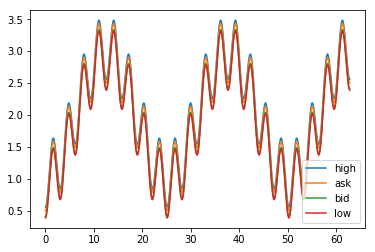

In [4]:
# Simulación del precio (ticks bid, ask) y predicted (high,low)
import matplotlib.pyplot as plt
x = np.linspace(0, 20*np.pi, 1000)
xc = np.linspace(0, 5*np.pi, 1000)
y_ask = 1.5 + ((np.sin(x) * np.sin(x)) - np.cos(xc))
y_bid = y_ask - np.random.random_sample()/10
y_high = y_ask + np.random.random_sample()/10
y_low  = y_bid - np.random.random_sample()/10

plt.plot(x, y_high)
plt.plot(x, y_ask)
plt.plot(x, y_bid)
plt.plot(x, y_low)
plt.legend(['high','ask','bid','low'])

Now, let's define a pair of callbacks to:

- Get predictions from LSTM 1st stage

- Get real time quotes from trading platform

In both cases, I provide simulated data (based on previous chart series) in order to test the environment.

In [5]:
# Callbacks to get predictions and quotes

#######################################################################################
def pull_predicted_data(step):
  return {'high':y_high[step], 'low':y_low[step]}

    
#######################################################################################
def pull_last_tick(instrument, step):
  return {'ask':y_ask[step], 'bid':y_bid[step]}

Now, I create and configure the trading environment:

In [6]:
# environment creation
env = TradeSimEnv()

# environment configuration
env.configure(steps_per_episode=x.shape[0]-1,      
              max_price=10 * np.max(y_high), 
              max_balance=10000.0, 
              max_pl=10000.0, 
              cb_pull_predictions=pull_predicted_data, 
              cb_pull_ticks=pull_last_tick,
              cb_market_info=None)


At this point, I can start the environment and execute random actions. At the end I use the stats report to show:

- Step by step rewards
- Accumulated total rewards
- Account's Balance
- Symbols where positions have been opened and closed

Episode End!


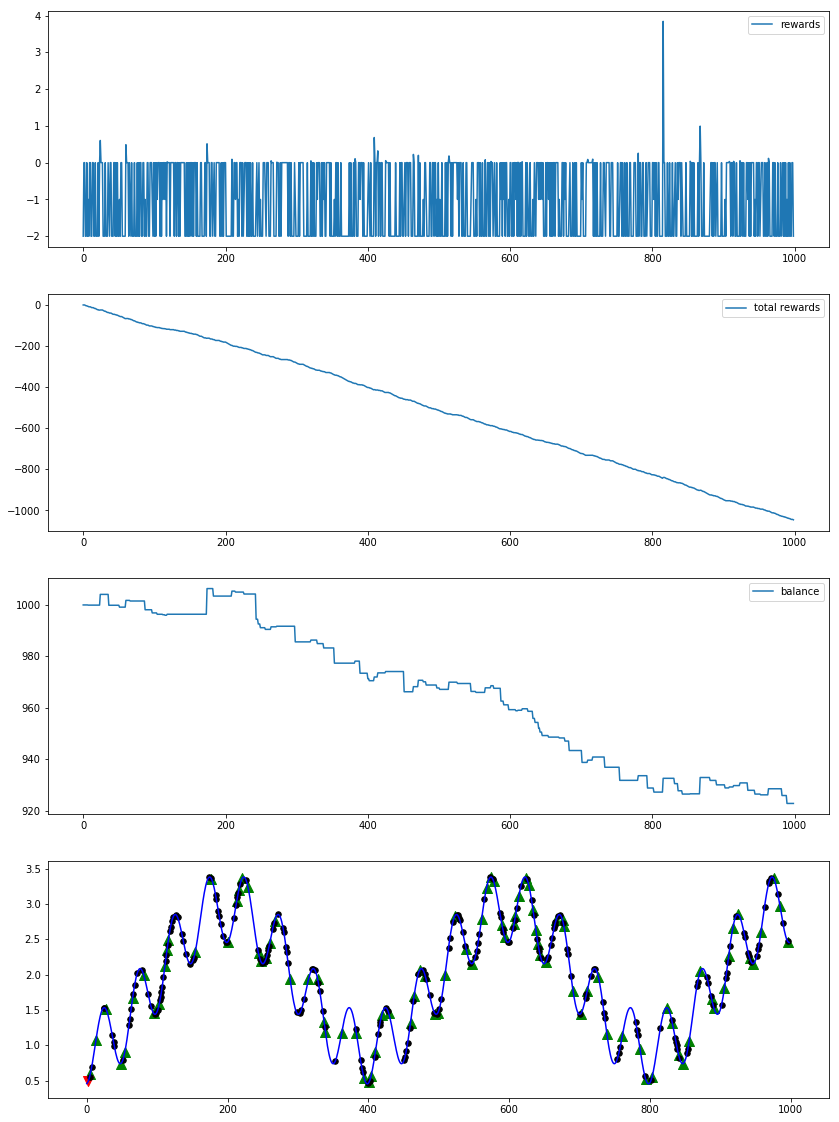

In [7]:
# Estado inicial
obs = env.reset()
done = False

while not done:
  # Ejecuta una acción aleatoria
  action=env.action_space.sample()
  #print('\r\nAction:',action)
  state, reward, done, info = env.step(action)
  #print('\r\nState:',state)
  #print('\r\nReward:',reward)
  #print('\r\nDone:',done)
  #print('\r\nInfo:',info)
  #done = True
  
print('Episode End!')

# obtengo las estadísticas del episodio actual
stats = env.statistics()

# Visualiza el resultado del episodio
plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.plot(np.asarray(stats['rewards']))
plt.legend(['rewards'])
plt.subplot(4,1,2)
plt.plot(np.cumsum(np.asarray(stats['rewards'])))
plt.legend(['total rewards'])
plt.subplot(4,1,3)
plt.plot(np.asarray(stats['balances']))
plt.legend(['balance'])

# Obtengo el precio como punto medio entre bid-ask (descarto el estado inicial)
price = (y_bid + y_ask)/2
price = price[1:]

# Obtengo un array con los índices de apertura long, short y cierre
x_marker_open_long = np.where(np.asarray(stats['pos_open_long']) > 0)[0]
x_marker_open_short = np.where(np.asarray(stats['pos_open_short']) > 0)[0]
x_marker_close = np.where(np.asarray(stats['pos_close']) > 0)[0]

# Obtengo un array con los valores de apertura long, short y cierre
y_marker_open_long = np.asarray(stats['pos_open_long']) * price[:np.asarray(stats['pos_open_long']).shape[0]]
y_marker_open_short = np.asarray(stats['pos_open_short']) * price[:np.asarray(stats['pos_open_short']).shape[0]]
y_marker_close = np.asarray(stats['pos_close']) * price[:np.asarray(stats['pos_close']).shape[0]]
y_marker_open_long = np.take(y_marker_open_long, x_marker_open_long)
y_marker_open_short = np.take(y_marker_open_short, x_marker_open_short)
y_marker_close = np.take(y_marker_close, x_marker_close)

plt.subplot(4,1,4)
# visualizo el precio
plt.plot(price, color='blue')
# las operaciones abiertas en largo
plt.scatter(x_marker_open_long, y_marker_open_long, marker='^', color='g', s=100)
# las abiertas en corto
plt.scatter(x_marker_open_short, y_marker_open_short, marker='v', color='r', s=100)
# las cerradas
plt.scatter(x_marker_close, y_marker_close, marker='o', color='black', s=30)
plt.show()

## 2. Environment test

Once the Trading Environment has been installed  `pip install -e .` it can be imported with package name `gym_tradesim`.
To execute this second section, reload the kernel and discard the execution of all previous cells.

In [1]:
# after reloading, reimport required libraries
import gym
import gym_tradesim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# show Gym registry and check if EnvSpec(TradeSim-v0)] appears
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v2), EnvSpec(BipedalWalkerHardcore-v2), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v2), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(Hopper-v2), EnvSpec(Swimmer-v2), EnvSpec(Walker2d-v2), EnvSpec(Ant-v2), EnvSpec(Hum

In [3]:
# Environment loading
env = gym.make('TradeSim-v0')

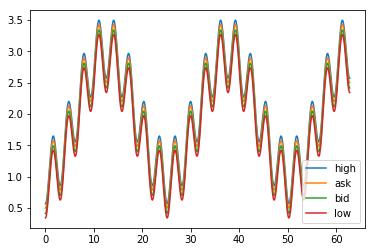

In [4]:
# Again, create simulation series for predictions and real time quotes
x = np.linspace(0, 20*np.pi, 1000)
xc = np.linspace(0, 5*np.pi, 1000)
y_ask = 1.5 + ((np.sin(x) * np.sin(x)) - np.cos(xc))
y_bid = y_ask - np.random.random_sample()/10
y_high = y_ask + np.random.random_sample()/10
y_low  = y_bid - np.random.random_sample()/10

plt.plot(x, y_high)
plt.plot(x, y_ask)
plt.plot(x, y_bid)
plt.plot(x, y_low)
plt.legend(['high','ask','bid','low'])

In [5]:
# environment configuration and callback setup

def pull_predicted_data(step):
  return {'high':y_high[step], 'low':y_low[step]}
    
def pull_last_tick(instrument, step):
  return {'ask':y_ask[step], 'bid':y_bid[step]}

env.env.configure(steps_per_episode=x.shape[0]-1,      
                  max_price=10 * np.max(y_high), 
                  max_balance=10000.0, 
                  max_pl=10000.0, 
                  cb_pull_predictions=pull_predicted_data, 
                  cb_pull_ticks=pull_last_tick,
                  cb_market_info=None)

In [6]:
# reset environment and show initial state
obs = env.reset()
obs

{'price_high': 0.5701119310834807,
 'price_low': 0.3423337498344133,
 'tick_ask': 0.5,
 'tick_bid': 0.4144862689907336,
 'acc_balance': 1000.0,
 'acc_floatpl': 0,
 'acc_pl': 0,
 'pos_long': 0,
 'pos_short': 0,
 'pos_price': 0,
 'pos_sl': 0,
 'pos_tp': 0}

Episode End!


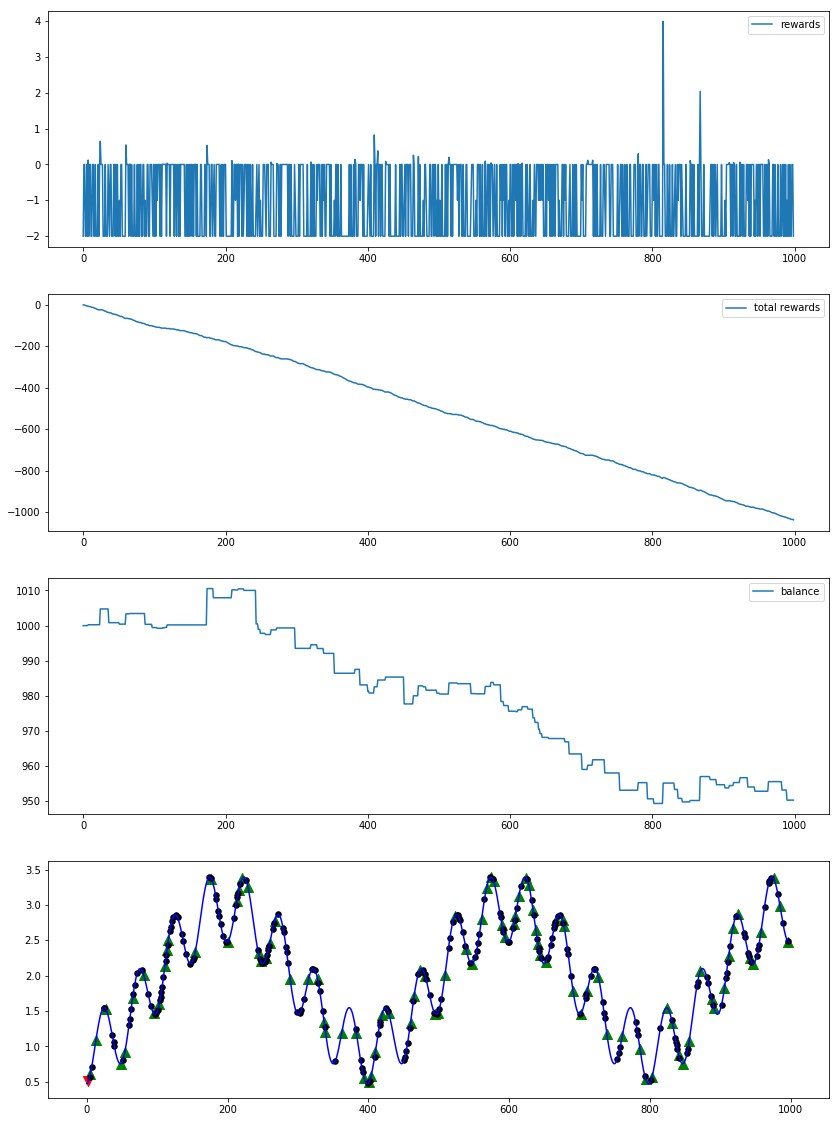

In [7]:
# reset again and execute random actions until the end of the episode
obs = env.reset()
done = False

while not done:
  # execute random action
  action=env.action_space.sample()
  #print('\r\nAction:',action)
  state, reward, done, info = env.step(action)
  #print('\r\nState:',state)
  #print('\r\nReward:',reward)
  #print('\r\nDone:',done)
  #print('\r\nInfo:',info)
  #done = True
  
print('Episode End!')

# get episode stats report
stats = env.env.statistics()

# Visualize stats
plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.plot(np.asarray(stats['rewards']))
plt.legend(['rewards'])
plt.subplot(4,1,2)
plt.plot(np.cumsum(np.asarray(stats['rewards'])))
plt.legend(['total rewards'])
plt.subplot(4,1,3)
plt.plot(np.asarray(stats['balances']))
plt.legend(['balance'])

# Get price as mean of bid-ask (discard initial value at step=0)
price = (y_bid + y_ask)/2
price = price[1:]

# Get arrays with indexes from long, short and close operations
x_marker_open_long = np.where(np.asarray(stats['pos_open_long']) > 0)[0]
x_marker_open_short = np.where(np.asarray(stats['pos_open_short']) > 0)[0]
x_marker_close = np.where(np.asarray(stats['pos_close']) > 0)[0]

# Get array with values from long, short and close operations
y_marker_open_long = np.asarray(stats['pos_open_long']) * price[:np.asarray(stats['pos_open_long']).shape[0]]
y_marker_open_short = np.asarray(stats['pos_open_short']) * price[:np.asarray(stats['pos_open_short']).shape[0]]
y_marker_close = np.asarray(stats['pos_close']) * price[:np.asarray(stats['pos_close']).shape[0]]
y_marker_open_long = np.take(y_marker_open_long, x_marker_open_long)
y_marker_open_short = np.take(y_marker_open_short, x_marker_open_short)
y_marker_close = np.take(y_marker_close, x_marker_close)

plt.subplot(4,1,4)
# visualize price
plt.plot(price, color='blue')
# opening long positions
plt.scatter(x_marker_open_long, y_marker_open_long, marker='^', color='g', s=100)
# opening short positions
plt.scatter(x_marker_open_short, y_marker_open_short, marker='v', color='r', s=100)
# closing positions
plt.scatter(x_marker_close, y_marker_close, marker='o', color='black', s=30)
plt.show()